In [1]:
import pathlib
from IPython.display import Code

import RATapi as RAT
from RATapi.models import Parameter

# Analysing Domains Samples Using Custom Layers Models

For custom models, all the work with calculating the reflectivity from the different domains is done within the custom model itself. To do this, there is an additional input into the custom model file which denotes the domain to be calculated:

The final 'domain' input is always either 0 or 1, denoting which domain is being calculated. Then, within the custom model, we can calculate the layers structure for whichever domain structure is required in this pass through the function:

We will make a simple example of a permalloy layer on silicon, which has spin up and spin down domains, each with different SLDs

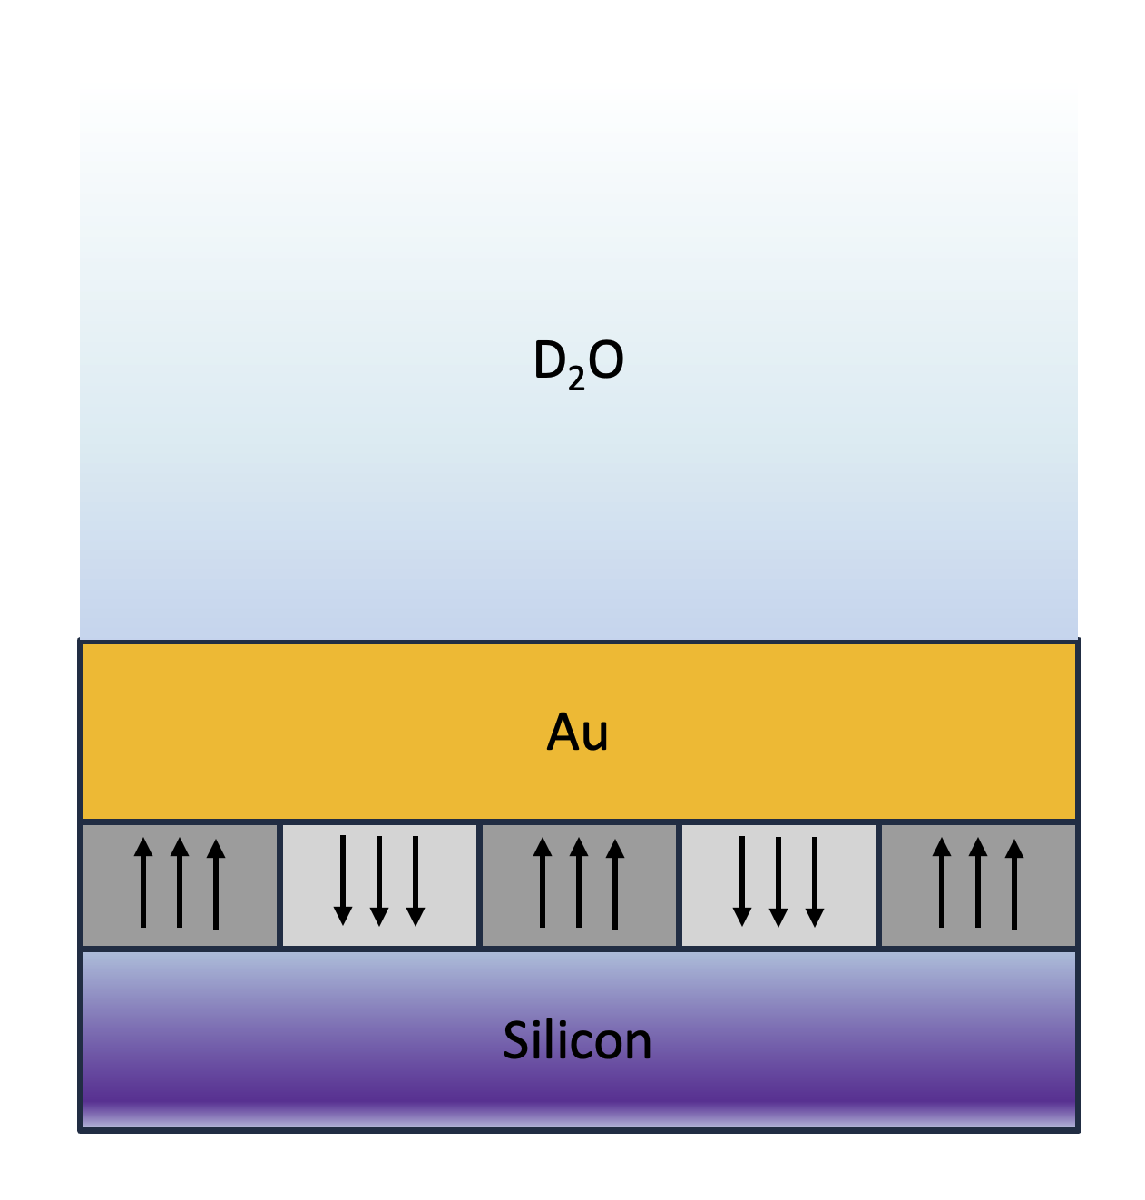
We start by setting up the project:


In [2]:
problem = RAT.Project(calculation="domains", model="custom layers", geometry="substrate/liquid")

# Make some parameters
parameter_list = [
    Parameter(name="Alloy Thickness", min=100.0, value=150.0, max=200.0, fit=True),
    Parameter(name="Alloy SLD up", min=9.0e-6, value=11.0e-6, max=13.0e-6, fit=True),
    Parameter(name="Alloy SLD down", min=5.0e-6, value=7.0e-6, max=10.0e-6, fit=True),
    Parameter(name="Alloy Roughness", min=5.0, value=7.0, max=11.0, fit=True),
    Parameter(name="Gold Thickness", min=100.0, value=150.0, max=200.0, fit=True),
    Parameter(name="Gold SLD", min=4.0e-6, value=4.5e-6, max=5.0e-6, fit=True),
    Parameter(name="Gold Roughness", min=5.0, value=7.0, max=11.0, fit=True)
]

problem.parameters.extend(parameter_list)

# Set the bulk SLD
problem.bulk_in.set_fields(0, name="Silicon", value=2.073e-6, max=1.0)

# Add the custom file
problem.custom_files.append(name="Alloy domains", filename="alloy_domains.py", language="python", path=pathlib.Path.cwd().resolve(),
)

# Make a contrast
problem.contrasts.append(
    name="D2O Contrast",
    data="Simulation",
    background="Background 1",
    bulk_in="Silicon",
    bulk_out="SLD D2O",
    scalefactor="Scalefactor 1",
    resolution="Resolution 1",
    resample=False,
    domain_ratio="Domain Ratio 1",
    model=["Alloy domains"],
)

print(problem)

Calculation: ---------------------------------------------------------------------------------------

domains

Model: ---------------------------------------------------------------------------------------------

custom layers

Geometry: ------------------------------------------------------------------------------------------

substrate/liquid

Parameters: ----------------------------------------------------------------------------------------

+-------+---------------------+-------+---------+---------+------+
| index |         name        |  min  |  value  |   max   | fit  |
+-------+---------------------+-------+---------+---------+------+
|   0   | Substrate Roughness |  1.0  |   3.0   |   5.0   | True |
|   1   |   Alloy Thickness   | 100.0 |  150.0  |  200.0  | True |
|   2   |     Alloy SLD up    | 9e-06 | 1.1e-05 | 1.3e-05 | True |
|   3   |    Alloy SLD down   | 5e-06 |  7e-06  |  1e-05  | True |
|   4   |   Alloy Roughness   |  5.0  |   7.0   |   11.0  | True |
|   5   |    G

In the project, we are using a custom function which we have called 'alloy_domains':

In [3]:
Code("alloy_domains.py")

def alloy_domains(params, bulkIn, bulkOut, contrast, domain):
    """Simple custom model for testing incoherent summing.
    Simple two layer of permalloy / gold, with up/down domains.
    """
    # Split up the parameters
    subRough = params[0]
    alloyThick = params[1]
    alloySLDup = params[2]
    alloySLDdn = params[3]
    alloyRough = params[4]
    goldThick = params[5]
    goldSLD = params[6]
    goldRough = params[7]

    # Make the layers
    alloyUp = [alloyThick, alloySLDup, alloyRough]
    alloyDn = [alloyThick, alloySLDdn, alloyRough]
    gold = [goldThick, goldSLD, goldRough]

    # Make the model depending on which domain we are looking at
    if domain == 0:
        output = [alloyUp, gold]
    else:
        output = [alloyDn, gold]

    return output, subRough

Note that the main difference between this and a 'normal' custom function is the extra 'domain' input, which we then use to select which domain we compute using the 'if / else' instruction at the end of the function

To run this, we make a controls block as usual, and send it to RAT.

Starting RAT ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Elapsed time is 0.004 seconds

Finished RAT ───────────────────────────────────────────────────────────────────────────────────────────────────────────



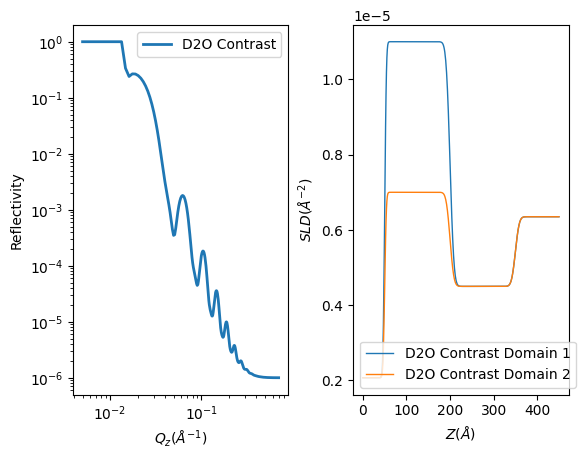

In [4]:
controls = RAT.Controls()
problem, results = RAT.run(problem, controls)

RAT.plotting.plot_ref_sld(problem, results)